In [2]:
import numpy as np
import numpy.linalg as LA
import jax
import jax.numpy as jnp
import jax.numpy.linalg as JLA

from jax.example_libraries import optimizers

import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import trange
from functools import partial
from sklearn.datasets import fetch_openml

In [3]:
A = jnp.array([[-0.2, 0.4, -1.0, -0.4],
    [-0.7, -0.8, -0.6, -0.3],
    [-0.2, 0.1, -0.2, 0.4],
    [-0.6, 0.8, -0.9, 0.3]])

In [4]:
eig, _ = JLA.eig(A)
print(eig)

[ 0.5799    +0.j         -0.5352528 +0.79588944j -0.5352528 -0.79588944j
 -0.40939507+0.j        ]


In [5]:
B = jnp.array([[-0.2, 0.1],
    [-0.7, -0.6],
    [0.6, 0.9],
    [-0.4, 0.4]])

In [6]:
C = jnp.array([[0.8, 0.8, -0.8, -0.9],
    [-0.7, 0.8, -0.8, -0.2]])

In [7]:
K = jnp.array([[-2.7, 2.7],
                [2.7, -2.7]])

In [8]:
eig, _ = JLA.eig(A + B @ K @ C)
print(eig)

[-0.17348303+1.6375853j -0.17348303-1.6375853j -0.696594  +0.j
 -0.15343916+0.j       ]


In [9]:
T = 20.0
N = 500
eta = T/N

In [10]:
def Euler(K):
    x = jnp.ones(4)
    x_trj = jnp.zeros((4, N))
    for i in range(N):
        x += eta * (A + B @ K @ C) @ x
        x_trj = x_trj.at[:, i].set(x)
    return x_trj[0,:], x_trj[1,:], x_trj[2,:], x_trj[3,:]

In [11]:
x1, x2, x3, x4 = Euler(K)
df = pd.DataFrame()
df["t"] = jnp.arange(eta, T+eta, eta)
df["x_1"] = x1
df["x_2"] = x2
df["x_3"] = x3
df["x_4"] = x4

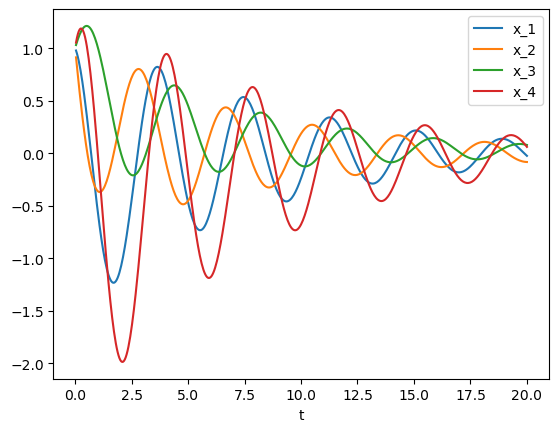

In [12]:
df.plot(df.columns[0], y = df.columns[1:]);

In [13]:
@jax.jit
def DU_Euler(K):
    x = jnp.ones(4)
    for i in range(N):
        x += eta * (A + B @ K @ C) @ x
    return JLA.norm(x)**2

In [14]:
adam_lr = 1e-0
train_itr = 20

opt_init, opt_update, get_params = optimizers.adam(adam_lr)

def train(gain_k):
    opt_state = opt_init(gain_k)
    for i in range(train_itr):
        value, grads = jax.value_and_grad(DU_Euler, argnums=-1)(get_params(opt_state))
        opt_state = opt_update(i, grads, opt_state)
        print("\r"+"\rloss:{}".format(value), end=" ")
    return get_params(opt_state)

In [15]:
gain_k_init = jnp.ones((2,2))
gain_k_trained = train(gain_k_init)

loss:0.001191041781567037   

In [16]:
x1, x2, x3, x4 = Euler(gain_k_trained)
df2 = pd.DataFrame()
df2["t"] = jnp.arange(eta, T+eta, eta)
df2["x_1"] = x1
df2["x_2"] = x2
df2["x_3"] = x3
df2["x_4"] = x4

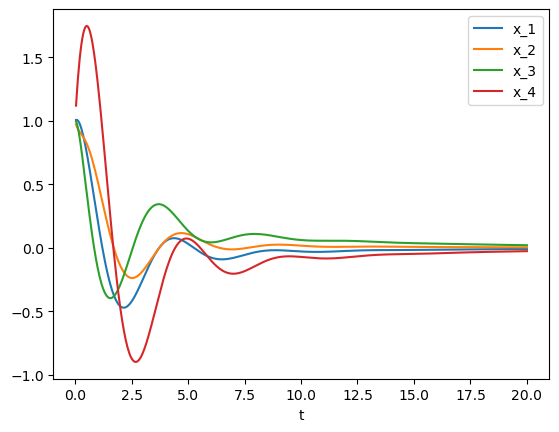

In [17]:
df2.plot(df2.columns[0], y = df2.columns[1:]);